# Course : AAI-510 Machine Learning Fundamentals and Application
## Final Project Group5 Members:
**1. Sandeep Kumar Jakkaraju**  
**2. Harish Kapettu Acharya**  
**3. John Kalaiselvan**

## Dataset
https://archive.ics.uci.edu/ml/datasets/PAMAP2+Physical+Activity+Monitoring  

### About The Data Set:
The dataset used in this project contains wearable sensor data collected from various body parts (e.g., hand, chest, ankle). Each record is labeled with an activity class(such as walking, cycling, playing soccer, etc.), which we aim to classify using machine learning models.

## Import of the required libraries

We import common libraries used for data manipulation (like pandas and numpy), visualization (matplotlib and seaborn), and machine learning (sklearn, xgboost, shap). These form the backbone for EDA, preprocessing, model training, and interpretation. Data preprocessing is essential to prepare the dataset for modeling. This includes handling missing values, normalizing sensor data, and encoding activity labels.

In [1]:
import os
import sys
import re
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import shap

from matplotlib import pyplot as plt
from IPython.display import display

from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from xgboost import XGBClassifier

from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Input, LSTM, Dropout

## Data pre-processing

### Download dataset

In [2]:
# Define the list of target files
list_of_files = [
    'PAMAP2_Dataset/PAMAP2_Dataset/PAMAP2_Dataset/Protocol/subject105.dat',
    'PAMAP2_Dataset/PAMAP2_Dataset/PAMAP2_Dataset/Protocol/subject109.dat',
    'PAMAP2_Dataset/PAMAP2_Dataset/PAMAP2_Dataset/Protocol/subject108.dat',
    'PAMAP2_Dataset/PAMAP2_Dataset/PAMAP2_Dataset/Protocol/subject104.dat',
    'PAMAP2_Dataset/PAMAP2_Dataset/PAMAP2_Dataset/Protocol/subject106.dat',
    'PAMAP2_Dataset/PAMAP2_Dataset/PAMAP2_Dataset/Protocol/subject107.dat',
    'PAMAP2_Dataset/PAMAP2_Dataset/PAMAP2_Dataset/Protocol/subject102.dat',
    'PAMAP2_Dataset/PAMAP2_Dataset/PAMAP2_Dataset/Protocol/subject101.dat',
    'PAMAP2_Dataset/PAMAP2_Dataset/PAMAP2_Dataset/Protocol/subject103.dat'
]

# Check if all target files exist
all_files_exist = all(os.path.exists(file) for file in list_of_files)

if not all_files_exist:
    # Download the dataset
    url = "https://archive.ics.uci.edu/static/public/231/pamap2+physical+activity+monitoring.zip"
    filename = "PAMAP2_Dataset.zip"
    extracted_dir = "PAMAP2_Dataset"

    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        get_ipython().system(f'wget {url} -O {filename}')
    else:
        print(f"{filename} already exists. Skipping download.")

    # Extract the main ZIP file
    if not os.path.exists(extracted_dir):
        os.makedirs(extracted_dir)

    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(extracted_dir)
    print(f"Extracted {filename} to {extracted_dir}")

    # Unzip nested ZIP files
    for root, dirs, files in os.walk(extracted_dir):
        for file in files:
            if file.endswith(".zip"):
                file_path = os.path.join(root, file)
                nested_extract_path = os.path.splitext(file_path)[0]  # same name folder

                print(f"Unzipping nested file: {file_path}")
                with zipfile.ZipFile(file_path, 'r') as zip_ref:
                    zip_ref.extractall(nested_extract_path)

    # Remove the ZIP files
    for root, dirs, files in os.walk(extracted_dir):
        for file in files:
            if file.endswith(".zip"):
                file_path = os.path.join(root, file)
                os.remove(file_path)
                print(f"Removed {file_path}")
else:
    print("All target files already exist. Skipping download and extraction.")

# You can optionally list the extracted files to confirm
if not all_files_exist:
    print("\nFiles in the extracted directory:")
    for root, dirs, files in os.walk(extracted_dir):
        for file in files:
            print(os.path.join(root, file))

--2025-06-18 13:59:35--  https://archive.ics.uci.edu/static/public/231/pamap2+physical+activity+monitoring.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘PAMAP2_Dataset.zip’

PAMAP2_Dataset.zip      [     <=>            ] 656.34M  45.9MB/s    in 13s     

2025-06-18 13:59:48 (52.0 MB/s) - ‘PAMAP2_Dataset.zip’ saved [688226940]

Extracted PAMAP2_Dataset.zip to PAMAP2_Dataset
Unzipping nested file: PAMAP2_Dataset/PAMAP2_Dataset.zip
Removed PAMAP2_Dataset/PAMAP2_Dataset.zip

Files in the extracted directory:
PAMAP2_Dataset/readme.pdf
PAMAP2_Dataset/PAMAP2_Dataset/PAMAP2_Dataset/readme.pdf
PAMAP2_Dataset/PAMAP2_Dataset/PAMAP2_Dataset/subjectInformation.pdf
PAMAP2_Dataset/PAMAP2_Dataset/PAMAP2_Dataset/PerformedActivitiesSummary.pdf
PAMAP2_Dataset/PAMAP2_Dataset/PAMAP2_Dataset/DataCollectionProtocol

### Load data

In [3]:
activityIDDict = {0: 'transient',
              1: 'lying',
              2: 'sitting',
              3: 'standing',
              4: 'walking',
              5: 'running',
              6: 'cycling',
              7: 'Nordic_walking',
              9: 'watching_TV',
              10: 'computer_work',
              11: 'car driving',
              12: 'ascending_stairs',
              13: 'descending_stairs',
              16: 'vacuum_cleaning',
              17: 'ironing',
              18: 'folding_laundry',
              19: 'house_cleaning',
              20: 'playing_soccer',
              24: 'rope_jumping' }

colNames = ["timeStamp", "activityID", "heartRate",
            "handTemp",
            "handAcc16gX", "handAcc16gY", "handAcc16gZ",
            "handAcc6gX", "handAcc6gY", "handAcc6gZ",
            "handGyroX", "handGyroY", "handGyroZ",
            "handMagX", "handMagY", "handMagZ",
            "handOriX", "handOriY", "handOriZ", "handOriW",
            "chestTemp",
            "chestAcc16gX", "chestAcc16gY", "chestAcc16gZ",
            "chestAcc6gX", "chestAcc6gY", "chestAcc6gZ",
            "chestGyroX", "chestGyroY", "chestGyroZ",
            "chestMagX", "chestMagY", "chestMagZ",
            "chestOriX", "chestOriY", "chestOriZ", "chestOriW",
            "ankleTemp",
            "ankleAcc16gX", "ankleAcc16gY", "ankleAcc16gZ",
            "ankleAcc6gX", "ankleAcc6gY", "ankleAcc6gZ",
            "ankleGyroX", "ankleGyroY", "ankleGyroZ",
            "ankleMagX", "ankleMagY", "ankleMagZ",
            "ankleOriX", "ankleOriY", "ankleOriZ", "ankleOriW"]

# Collect dataframes from each file
dfs_list = []
for file in list_of_files:
    temp_df = pd.read_table(file, header=None, sep='\s+')
    temp_df.columns = colNames

    # Extract subject ID
    match = re.search(r'subject(\d+)\.dat', file)
    if match:
        temp_df['subjectID'] = int(match.group(1))
    else:
        print(f"Could not extract subject ID from filename: {file}")
        temp_df['subjectID'] = None

    # Append the temporary dataframe to the list
    dfs_list.append(temp_df)

# Concatenate all dataframes in the list into a single dataframe
df = pd.concat(dfs_list, ignore_index=True)

df.reset_index(drop=True, inplace=True)
display(df.head())

,timeStamp,activityID,heartRate,handTemp,handAcc16gX,handAcc16gY,handAcc16gZ,handAcc6gX,handAcc6gY,handAcc6gZ,...,ankleGyroY,ankleGyroZ,ankleMagX,ankleMagY,ankleMagZ,ankleOriX,ankleOriY,ankleOriZ,ankleOriW,subjectID
0,5.70,0,NaN,34.0,2.22755,9.65418,2.38862,2.31968,9.60752,2.58278,...,0.009340,0.050097,-32.7091,31.4772,44.2318,0.255373,0.783075,0.084602,0.560732,105
1,5.71,0,NaN,34.0,2.37550,9.57647,2.31412,2.45657,9.62177,2.71852,...,0.002312,0.053832,-33.0782,30.9814,44.5148,0.251163,0.785583,0.076319,0.560314,105
2,5.72,0,NaN,34.0,2.94208,9.53415,2.32275,2.78876,9.64961,2.76342,...,0.034249,0.030462,-32.5619,30.6982,44.5169,0.250643,0.786419,0.072038,0.559941,105
3,5.73,0,NaN,34.0,3.47541,9.75837,2.40696,3.33080,9.66073,2.68734,...,0.058615,0.055252,-32.8212,30.9690,44.6575,0.250917,0.786967,0.071013,0.559179,105
4,5.74,0,NaN,34.0,3.54617,9.83232,2.25382,3.67642,9.71848,2.50565,...,0.020903,0.059653,-33.1869,30.0856,44.5154,0.249631,0.786602,0.066861,0.560777,105


## Exploratory Data Analysis

We begin with exploratory data analysis (EDA) to understand the distribution of sensor readings and activity labels. This helps uncover patterns and anomalies before model training.

### Data overview

In [4]:
# Dataframe shape
display(df.shape)

(2872533, 55)

In [5]:
# Dataframe info
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2872533 entries, 0 to 2872532
Data columns (total 55 columns):
 #   Column        Dtype  
---  ------        -----  
 0   timeStamp     float64
 1   activityID    int64  
 2   heartRate     float64
 3   handTemp      float64
 4   handAcc16gX   float64
 5   handAcc16gY   float64
 6   handAcc16gZ   float64
 7   handAcc6gX    float64
 8   handAcc6gY    float64
 9   handAcc6gZ    float64
 10  handGyroX     float64
 11  handGyroY     float64
 12  handGyroZ     float64
 13  handMagX      float64
 14  handMagY      float64
 15  handMagZ      float64
 16  handOriX      float64
 17  handOriY      float64
 18  handOriZ      float64
 19  handOriW      float64
 20  chestTemp     float64
 21  chestAcc16gX  float64
 22  chestAcc16gY  float64
 23  chestAcc16gZ  float64
 24  chestAcc6gX   float64
 25  chestAcc6gY   float64
 26  chestAcc6gZ   float64
 27  chestGyroX    float64
 28  chestGyroY    float64
 29  chestGyroZ    float64
 30  chestMagX     floa

None

In [6]:
# Summary of statistics
display(df.describe())

,timeStamp,activityID,heartRate,handTemp,handAcc16gX,handAcc16gY,handAcc16gZ,handAcc6gX,handAcc6gY,handAcc6gZ,...,ankleGyroY,ankleGyroZ,ankleMagX,ankleMagY,ankleMagZ,ankleOriX,ankleOriY,ankleOriZ,ankleOriW,subjectID
count,2.872533e+06,2.872533e+06,262268.000000,2.859392e+06,2.859392e+06,2.859392e+06,2.859392e+06,2.859392e+06,2.859392e+06,2.859392e+06,...,2.860784e+06,2.860784e+06,2.860784e+06,2.860784e+06,2.860784e+06,2.860784e+06,2.860784e+06,2.860784e+06,2.860784e+06,2.872533e+06
mean,1.834354e+03,5.466243e+00,109.872508,3.265258e+01,-4.960786e+00,3.587758e+00,3.168417e+00,-4.889420e+00,3.584267e+00,3.349479e+00,...,-3.450122e-02,7.752030e-03,-3.272102e+01,1.593304e+00,1.689044e+01,3.986417e-01,2.154835e-02,3.091533e-01,-1.878725e-02,1.045005e+02
std,1.105689e+03,6.331333e+00,25.870036,1.844274e+00,5.985029e+00,6.277838e+00,3.843923e+00,5.992726e+00,6.055750e+00,3.840650e+00,...,5.966026e-01,1.842552e+00,1.887860e+01,2.161181e+01,2.030858e+01,3.034561e-01,5.691302e-01,3.237875e-01,4.731373e-01,2.367003e+00
min,5.640000e+00,0.000000e+00,57.000000,2.475000e+01,-1.453670e+02,-1.043010e+02,-1.014520e+02,-6.148950e+01,-6.186800e+01,-6.193470e+01,...,-1.812690e+01,-1.401960e+01,-1.728650e+02,-1.379080e+02,-1.092890e+02,-2.536280e-01,-9.568760e-01,-8.768380e-01,-9.972810e-01,1.010000e+02
25%,8.931600e+02,0.000000e+00,90.000000,3.143750e+01,-9.028420e+00,1.290268e+00,9.685818e-01,-8.933270e+00,1.284680e+00,1.164040e+00,...,-8.267093e-02,-3.084595e-01,-4.289480e+01,-1.148540e+01,3.289348e+00,1.563440e-01,-5.839910e-01,1.087023e-02,-5.047580e-01,1.020000e+02
50%,1.790830e+03,3.000000e+00,108.000000,3.312500e+01,-5.788145e+00,3.570830e+00,2.958415e+00,-5.737615e+00,3.613430e+00,3.132855e+00,...,-4.249850e-03,-2.216015e-03,-3.390020e+01,1.362615e+00,1.809105e+01,3.197555e-01,0.000000e+00,3.043820e-01,0.000000e+00,1.050000e+02
75%,2.710570e+03,7.000000e+00,125.000000,3.400000e+01,-7.829420e-01,6.602720e+00,6.002930e+00,-7.249920e-01,6.601960e+00,6.257612e+00,...,8.296868e-02,6.343258e-02,-1.905920e+01,1.733090e+01,3.087820e+01,5.794420e-01,6.279450e-01,6.020032e-01,4.634432e-01,1.070000e+02
max,4.475630e+03,2.400000e+01,202.000000,3.550000e+01,6.285960e+01,1.556990e+02,1.577600e+02,5.282140e+01,6.225980e+01,6.194460e+01,...,1.358820e+01,1.652880e+01,9.752550e+01,1.233060e+02,1.469000e+02,1.000000e+00,9.595380e-01,9.923540e-01,9.961050e-01,1.090000e+02


The dataset comprises 2,872,533 rows and 55 columns. It contains sensor data from accelerometers, gyroscopes, magnetometers, orientation sensors, and temperature sensors placed on the hand, chest, and ankle of subjects. Each row corresponds to a time-stamped observation labeled with an `activityID` and `subjectID`. The dataset is suitable for time-series classification tasks such as human activity recognition.


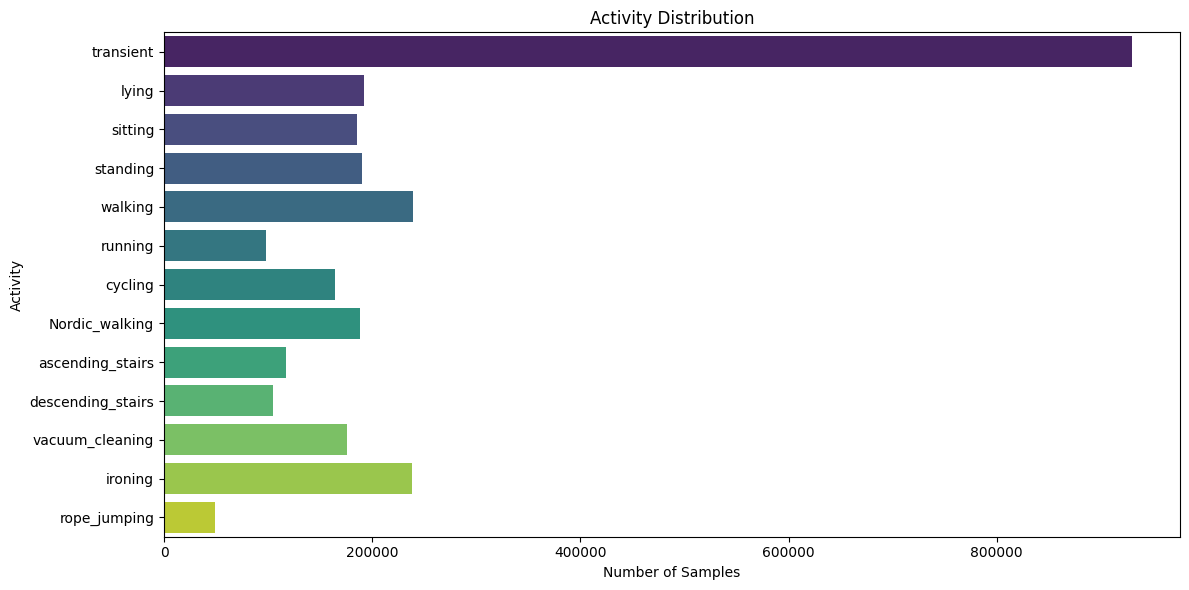

In [7]:
# Count frequencies by activityID
activity_counts = df['activityID'].value_counts().sort_index()

# Map IDs to labels without modifying df
labels = [activityIDDict.get(i, f'Unknown_{i}') for i in activity_counts.index]

# Plot class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=activity_counts.values, y=labels, hue=labels, palette='viridis')
plt.title("Activity Distribution")
plt.xlabel("Number of Samples")
plt.ylabel("Activity")
plt.tight_layout()
plt.show()

**Activity Distribution Analysis**

The bar plot below visualizes the distribution of samples across various physical activities in the dataset. The x-axis represents the **number of samples**, while the y-axis lists the **activity labels**.

- The **'transient'** activity dominates the dataset with the highest number of samples, indicating a large portion of the data consists of transitions or unclassified movements.
- Among the specific activities, **'walking'**, **'ironing'**, and **'Nordic_walking'** are relatively frequent, each having over 200,000 samples.
- On the other hand, activities like **'rope_jumping'**, **'running'**, and **'ascending_stairs'** are underrepresented with fewer samples.
- This imbalance in activity classes is an important factor to consider when training machine learning models, as underrepresented activities might result in poorer classification performance. Techniques such as resampling, class weighting, or data augmentation may be necessary to address this.


### Data cleaning

In [8]:
# Function to clean data
def dataCleaning(df):
  # Removal of orientation columns as they are not needed
  df = df.drop(["handOriX", "handOriY", "handOriZ", "handOriW",
                "chestOriX", "chestOriY", "chestOriZ", "chestOriW",
                "ankleOriX", "ankleOriY", "ankleOriZ", "ankleOriW"],
                axis = 1)

  ## Removal of accel data with scale ±6g as they are not precisely calibrated
  #df = df.drop(["handAcc6gX", "handAcc6gY", "handAcc6gZ",
  #              "chestAcc6gX", "chestAcc6gY", "chestAcc6gZ",
  #              "ankleAcc6gX", "ankleAcc6gY", "ankleAcc6gZ"],
  #              axis = 1)

  # Removal of any row of activity 0 as it is transient activity which it is not used
  df = df.drop(df[df.activityID == 0].index)

  # Removal of non numeric data in cells
  numeric_cols = df.select_dtypes(include=['number']).columns
  df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

  # removal of any remaining NaN value cells by constructing new data points in known set of data points
  df = df.interpolate()

  return df


In [9]:
# Clean data
df = dataCleaning(df)
df.reset_index(drop = True, inplace = True)
df.head(10)

,timeStamp,activityID,heartRate,handTemp,handAcc16gX,handAcc16gY,handAcc16gZ,handAcc6gX,handAcc6gY,handAcc6gZ,...,ankleAcc6gX,ankleAcc6gY,ankleAcc6gZ,ankleGyroX,ankleGyroY,ankleGyroZ,ankleMagX,ankleMagY,ankleMagZ,subjectID
0,104.50,1,NaN,34.6875,-9.00214,3.10187,2.31949,-8.73688,3.17823,2.57798,...,9.59232,0.498257,-2.11755,0.014686,0.019172,0.017190,-38.2428,-49.3220,12.2520,105
1,104.51,1,NaN,34.6875,-8.77219,3.17667,2.39966,-8.76727,3.16334,2.56294,...,9.63752,0.498304,-2.08752,-0.004786,-0.003672,0.019288,-37.9971,-48.9484,12.1106,105
2,104.52,1,NaN,34.6875,-9.11203,3.02787,2.43356,-8.79741,3.16355,2.56297,...,9.62267,0.468106,-2.04194,-0.025297,0.020647,0.021037,-38.7444,-49.2944,13.1012,105
3,104.53,1,NaN,34.6875,-8.95953,3.02704,2.47433,-8.81223,3.14860,2.60832,...,9.63766,0.331985,-2.04158,-0.039941,0.018389,-0.008956,-38.6244,-49.3025,12.3925,105
4,104.54,1,NaN,34.6875,-8.95847,3.17880,2.47383,-8.76702,3.13319,2.62341,...,9.62194,0.301528,-2.20788,0.015034,0.031196,0.003912,-37.9932,-48.6886,12.9613,105
5,104.55,1,98.0,34.6875,-8.85846,2.98521,2.12960,-8.67596,3.20804,2.62315,...,9.63719,0.241105,-2.14723,0.024780,0.014792,0.021114,-39.0174,-48.8971,12.2488,105
6,104.56,1,98.0,34.6875,-8.69822,3.13781,2.36241,-8.69166,3.19300,2.56280,...,9.65238,0.377270,-2.11748,0.035247,-0.001366,-0.008944,-38.2358,-49.5794,12.3942,105
7,104.57,1,98.0,34.6875,-8.77166,3.25254,2.39941,-8.64607,3.22289,2.57778,...,9.62230,0.483120,-2.13279,-0.013609,0.040446,0.012589,-38.8799,-49.2898,12.3916,105
8,104.58,1,98.0,34.6875,-8.69688,3.13814,2.40091,-8.60162,3.17722,2.53254,...,9.63765,0.513466,-2.05730,0.033967,-0.015082,-0.004349,-38.8740,-49.4180,12.6754,105
9,104.59,1,98.0,34.6875,-8.80757,2.95033,2.51535,-8.60111,3.23762,2.53240,...,9.65271,0.452988,-2.04205,0.025102,0.025282,0.015699,-38.7486,-49.1659,12.9592,105


In [10]:
# Check for null data
df.isnull().sum()

,0
timeStamp,0
activityID,0
heartRate,5
handTemp,0
handAcc16gX,0
handAcc16gY,0
handAcc16gZ,0
handAcc6gX,0
handAcc6gY,0
handAcc6gZ,0


In [12]:
# Assume heartrate as 100 for the first 5 measurements
df.loc[:5, 'heartRate'] = 100

In [13]:
# Check for null data
df.isnull().sum()

,0
timeStamp,0
activityID,0
heartRate,0
handTemp,0
handAcc16gX,0
handAcc16gY,0
handAcc16gZ,0
handAcc6gX,0
handAcc6gY,0
handAcc6gZ,0


### Data visualization

Text(0, 0.5, 'Activity')

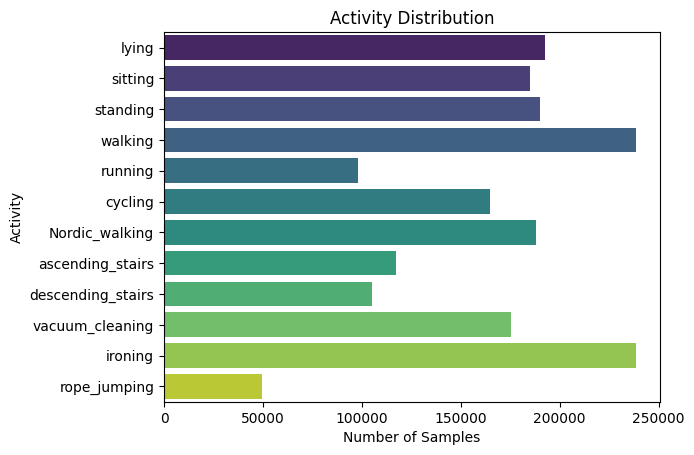

In [14]:
# Count frequencies by activityID
activity_counts = df['activityID'].value_counts().sort_index()

# Map IDs to labels without modifying df
labels = [activityIDDict.get(i, f'Unknown_{i}') for i in activity_counts.index]

# Activity Distribution plot
fig1, ax1 = plt.subplots()
#activity_df = activity_counts.reset_index()
#activity_df.columns = ['activity', 'count']

sns.barplot(x=activity_counts.values, y=labels, hue=labels, ax=ax1, palette='viridis')
ax1.set_title("Activity Distribution")
ax1.set_xlabel("Number of Samples")
ax1.set_ylabel("Activity")


**Activity Distribution After Data Cleaning**

The updated bar plot shows the distribution of activity samples after data cleaning. Compared to the original distribution, the transient activity class—previously overrepresented—has been removed or significantly reduced, leading to a more balanced dataset.

Key observations:
- The distribution across most activities such as **walking**, **ironing**, and **vacuum_cleaning** is now relatively uniform, with each having between 160,000 and 240,000 samples.
- **Rope_jumping** still has noticeably fewer samples (~50,000), which might introduce class imbalance during modeling. This could be addressed via techniques such as oversampling, class weighting, or data augmentation.
- Overall, the dataset is now more representative across a diverse set of activities, which enhances the fairness and generalizability of the model.

This cleaner distribution will likely result in improved model performance, especially for underrepresented activities in the previous version.

Text(0.5, 1.0, 'Correlation Heatmap of Sensor Features')

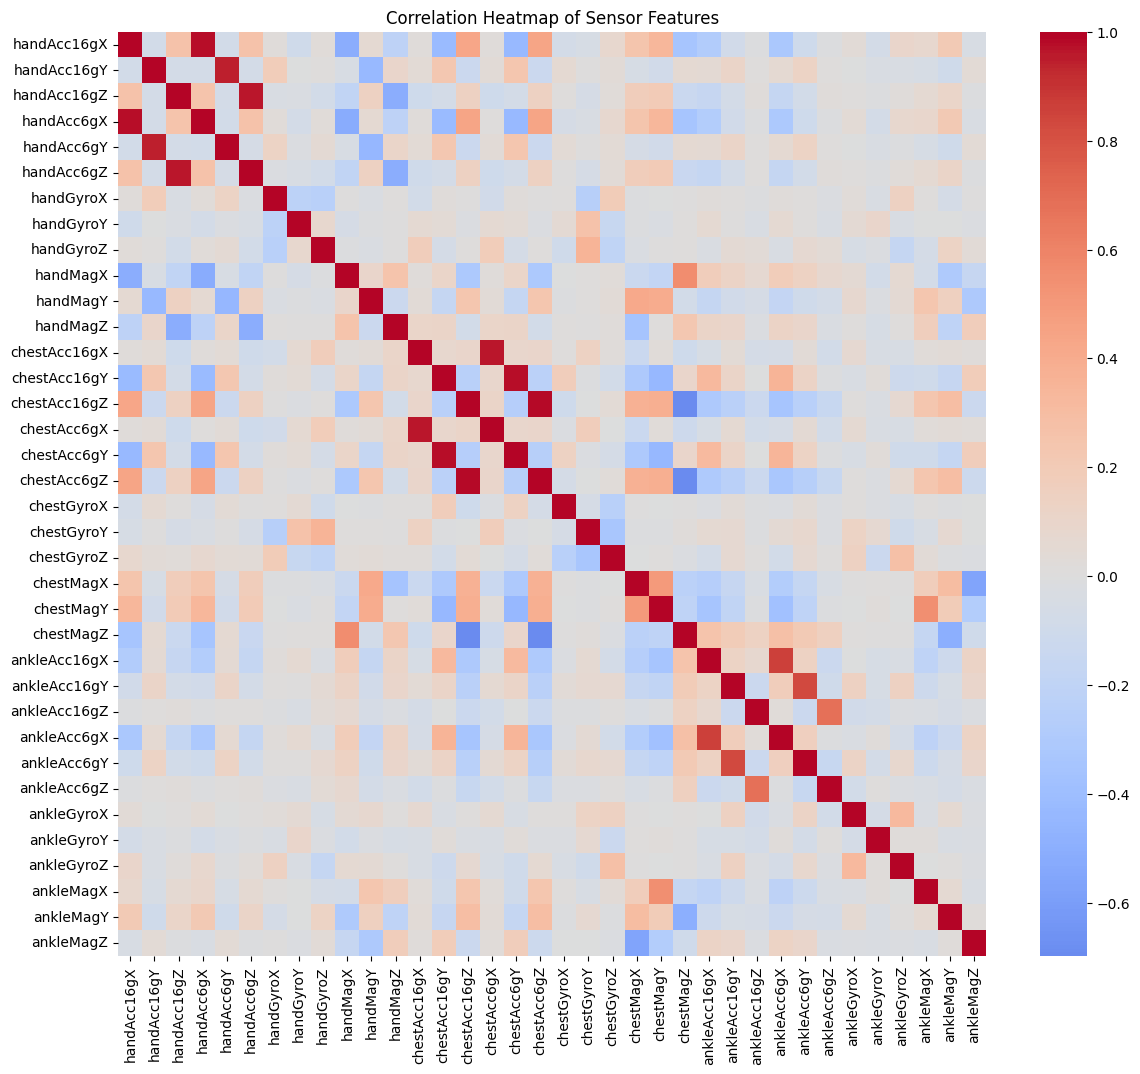

In [15]:
# Sensor correlation heatmap (only numeric columns and sensor-related)
sensor_columns = [col for col in df.columns if any(sensor in col for sensor in ['Acc', 'Gyro', 'Mag'])]
sensor_corr = df[sensor_columns].corr()

fig2, ax2 = plt.subplots(figsize=(14, 12))
sns.heatmap(sensor_corr, cmap='coolwarm', center=0, ax=ax2)
ax2.set_title("Correlation Heatmap of Sensor Features")

**Correlation Heatmap of Sensor Features**

The heatmap above visualizes the Pearson correlation coefficients between various sensor features collected from hand, chest, and ankle positions.

**Key observations:**
- **Strong correlations along sensor axes**: For each sensor position (e.g., hand, chest, ankle), the X, Y, and Z axes of the same sensor type (e.g., Acc16g, Acc6g) show strong positive correlations among themselves. This is expected due to the mechanical coupling of movement across axes.
- **Low inter-sensor correlation**: Most features across different sensor types and positions (e.g., hand vs. chest) exhibit weak correlations, suggesting that each sensor provides complementary and unique information, which is beneficial for classification tasks.
- **Red diagonal**: The diagonal is bright red (value of 1.0), indicating perfect correlation of features with themselves.
- **Blue regions**: Pockets of negative correlation are present but sparse and generally weak, which implies minimal redundancy in features.

This heatmap helps us confirm that:
- Multimodal sensor fusion is meaningful, as the features are not overly redundant.
- Dimensionality reduction methods like PCA could still be explored to further identify the most informative and least correlated feature sets.


<ipython-input-16-1734861306>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')


Text(0, 0.5, 'Accelerometer')

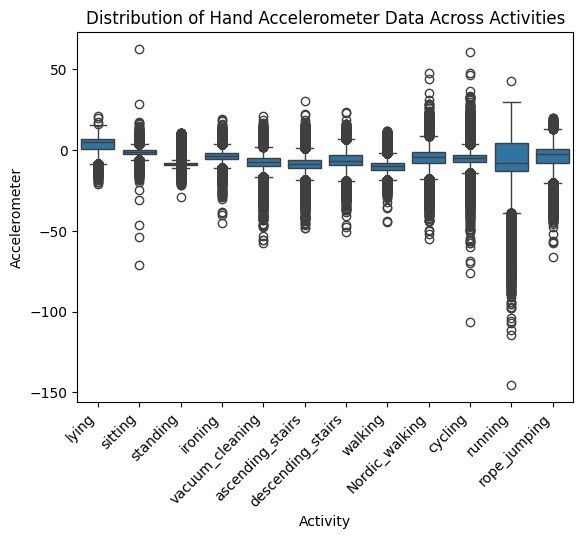

In [16]:
# Boxplot of accelerometer data for different activities
acc_columns = [col for col in df.columns if 'Acc' in col and 'X' in col]
fig3, ax3 = plt.subplots()

df_plot = df[df['activityID'] != 0].copy()
df_plot['activityLabel'] = df_plot['activityID'].map(activityIDDict)

sns.boxplot(x='activityLabel', y=acc_columns[0], data=df_plot, ax=ax3)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
ax3.set_title(f"Distribution of Hand Accelerometer Data Across Activities")
ax3.set_xlabel("Activity")
ax3.set_ylabel("Accelerometer")

**Distribution of Hand Accelerometer Data Across Activities**

The box plot above illustrates the distribution of hand accelerometer readings across different activities.

**Insights:**
- **Low-motion activities** such as *lying*, *sitting*, and *standing* exhibit a narrow range of accelerometer values clustered around zero, indicating minimal hand movement.
- **Moderate-motion activities** like *vacuum_cleaning*, *ironing*, and *walking* show slightly broader distributions, reflecting more frequent or consistent hand motions.
- **High-motion activities** such as *running* and *rope_jumping* display wide interquartile ranges and a large number of outliers, suggesting vigorous and variable hand movement.
- **Outliers** are prevalent in all activities but especially in dynamic ones, indicating sporadic high-magnitude accelerations.
- Activities like *ascending_stairs* and *descending_stairs* show negative skewness, likely due to dominant downward motion in those activities.

This visualization helps differentiate activity types based on hand movement patterns and justifies the inclusion of hand accelerometer features for activity recognition tasks.


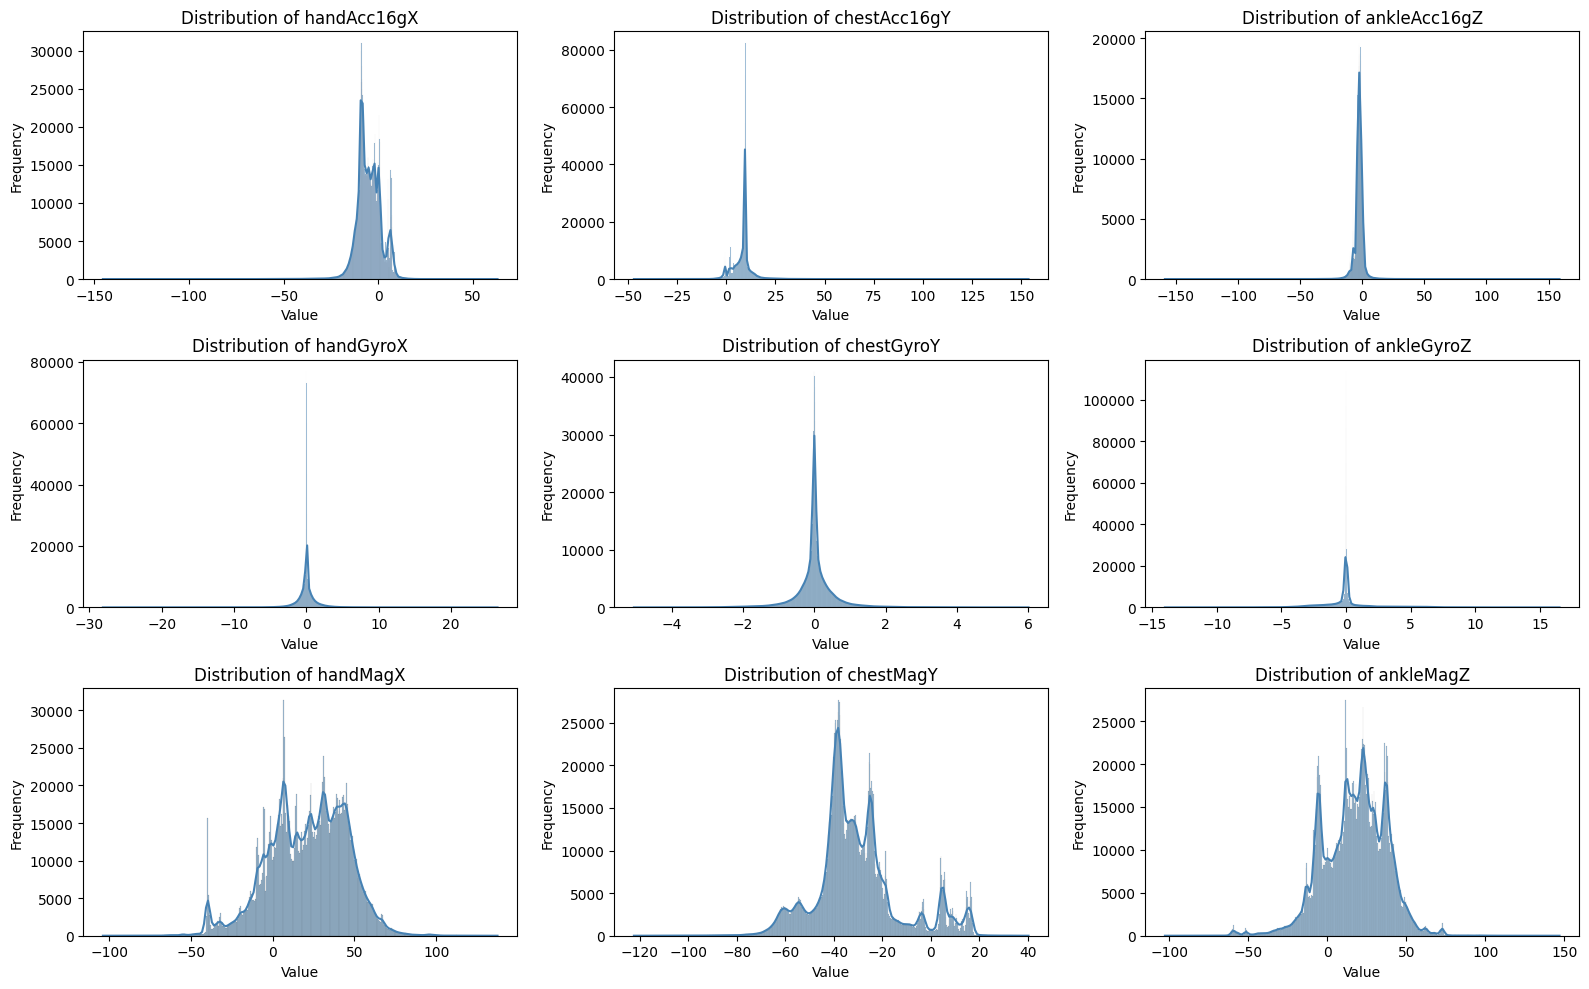

In [17]:
# Select representative features from different sensors
features_to_plot = [
    'handAcc16gX', 'chestAcc16gY', 'ankleAcc16gZ',
    'handGyroX', 'chestGyroY', 'ankleGyroZ',
    'handMagX', 'chestMagY', 'ankleMagZ'
]

# Set up the grid for plotting
n_cols = 3
n_rows = int(np.ceil(len(features_to_plot) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 10))
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(features_to_plot):
    sns.histplot(df[feature], kde=True, ax=axes[i], color='steelblue')
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()

**Histogram Distribution of Sensor Features**

The histograms above depict the distribution of selected sensor features from accelerometers, gyroscopes, and magnetometers placed at the hand, chest, and ankle positions.

**Key Observations:**

- **Accelerometers (Acc16g):**
  - Most accelerometer signals (e.g., `handAcc16gX`, `chestAcc16gY`, `ankleAcc16gZ`) show a sharp, peaked distribution centered around a narrow range.
  - These distributions suggest that most movement readings cluster around a small range of acceleration, with fewer extreme values.
  - Some axes show skewness — e.g., `handAcc16gX` is left-skewed while `chestAcc16gY` has a long right tail, indicating asymmetry in movement.

- **Gyroscopes:**
  - All gyroscope signals (`handGyroX`, `chestGyroY`, `ankleGyroZ`) show strong central peaks around zero with a symmetric shape, suggesting most angular velocity values are small and occasional large values may represent significant rotational motion.
  - The high peak indicates consistent low rotation across most timeframes.

- **Magnetometers:**
  - Magnetometer readings (`handMagX`, `chestMagY`, `ankleMagZ`) have multi-modal and broader distributions, indicating variability in magnetic field strength, possibly due to environmental interference or varying body orientation.
  - These distributions are far more irregular and dispersed compared to accelerometer and gyroscope readings.

**Overall:**
- Accelerometer and gyroscope readings are sharply centered, showing low variance in movement during most activities, punctuated by bursts of higher motion.
- Magnetometer readings exhibit high variance and multi-modality, highlighting their sensitivity to surrounding environments.

This analysis helps understand the raw sensor behavior before feature engineering or normalization.


### Outlier detection

In [18]:
# Select a subset of numeric features for outlier detection
features_for_outlier_detection = [
    'handAcc16gX', 'chestAcc16gY', 'ankleAcc16gZ',
    'handGyroX', 'chestGyroY', 'ankleGyroZ',
    'handMagX', 'chestMagY', 'ankleMagZ'
]

# Extract just those features
X = df[features_for_outlier_detection]

# Use Isolation Forest for outlier detection
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df['outlier'] = iso_forest.fit_predict(X)

# Count how many outliers were found (-1 indicates outlier)
outlier_counts = df['outlier'].value_counts()
outlier_counts

,count
outlier,
1,1923443
-1,19429


**Outlier Detection Summary**

The dataset contains a total of **1,943,872** samples, out of which:

- **1,923,443 samples** were identified as **inliers** (`outlier = 1`)
- **19,429 samples** were identified as **outliers** (`outlier = -1`)

This indicates that approximately **1% of the data** was flagged as anomalous. These outliers could correspond to unusual sensor behavior or rare physical activities, and may either be removed or analyzed further depending on the modeling goals (e.g., improving classifier robustness vs. detecting rare events).


## Data modeling

## Baseline model with Random Forest

In [19]:
# Group by subject and activity and create window-based features
def extract_features(df, window_size=100, step_size=50):
    features = []
    labels = []
    subject_ids = []
    feature_names = [] # Initialize list for feature names

    # Get the base columns that are not 'activityID', 'subjectID', 'timeStamp'
    base_cols = [col for col in df.columns if col not in ['activityID', 'subjectID', 'timeStamp']]

    # Generate the feature names based on the aggregation functions
    # This needs to be done only once
    if not feature_names:
        for col in base_cols:
            feature_names.extend([
                f"{col}_mean", f"{col}_std", f"{col}_min",
                f"{col}_max", f"{col}_median"
            ])


    for start in range(0, len(df) - window_size, step_size):
        end = start + window_size
        window = df.iloc[start:end]
        # Use .mode() to handle potential multiple modes, [0] gets the first
        label = window['activityID'].mode()[0]
        subject_id = window['subjectID'].mode()[0]


        feature_vector = []
        for col in base_cols:
            vals = window[col].values
            feature_vector.extend([
                np.mean(vals), np.std(vals), np.min(vals),
                np.max(vals), np.median(vals)
            ])

        features.append(feature_vector)
        labels.append(label)
        subject_ids.append(subject_id)

    # Return feature_names along with the arrays
    return np.array(features), np.array(labels), np.array(subject_ids), feature_names

In [20]:
# Split train, test data
X, y, groups, feature_names = extract_features(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### Training RandomForest Classifier and evaluation

In [21]:
# Train a RandomForest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [22]:
# Evaluate the model
y_pred = clf.predict(X_test)

print("Classification Report:")
clf_classification_report = classification_report(y_test, y_pred)
print(clf_classification_report)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       770
           2       0.99      0.98      0.99       741
           3       0.98      0.99      0.98       760
           4       1.00      0.99      0.99       955
           5       1.00      0.98      0.99       393
           6       0.99      1.00      1.00       659
           7       0.99      1.00      1.00       752
          12       0.98      0.96      0.97       468
          13       0.96      0.97      0.97       420
          16       0.96      0.99      0.98       702
          17       0.99      0.99      0.99       955
          24       0.99      0.98      0.99       197

    accuracy                           0.99      7772
   macro avg       0.99      0.99      0.99      7772
weighted avg       0.99      0.99      0.99      7772

Confusion Matrix:
[[767   0   0   0   0   0   0   0   0   2   0   1]
 [  1 724   7   0   0   0   0   0   0   9

In [23]:
# Accuracy score
clf_accuracy_score = accuracy_score(y_test, y_pred)
print("Accuracy:", clf_accuracy_score)

Accuracy: 0.9877766340710242


### Subject-wise cross validation

In [ ]:
# Get the encoded labels from LabelEncoder
#encoded_labels = label_encoder.classes_  # These are the original activity IDs, like [1, 2, 3, ..., 24]

# Map encoded labels to activity names
encoded_labels = labels
activity_names = [activityIDDict.get(id, f"Unknown {id}") for id in encoded_labels]

print(activity_names)

['Unknown lying', 'Unknown sitting', 'Unknown standing', 'Unknown walking', 'Unknown running', 'Unknown cycling', 'Unknown Nordic_walking', 'Unknown ascending_stairs', 'Unknown descending_stairs', 'Unknown vacuum_cleaning', 'Unknown ironing', 'Unknown rope_jumping']



Fold 1 Classification Report:
              precision    recall  f1-score   support

           1       0.91      0.98      0.95       473
           2       0.99      0.72      0.83       538
           3       0.82      0.73      0.77       442
           4       0.09      0.01      0.01       641
           5       1.00      0.88      0.94       493
           6       1.00      0.06      0.11       492
           7       0.99      0.83      0.90       525
          12       0.28      0.88      0.43       285
          13       0.52      0.75      0.61       255
          16       0.42      0.90      0.57       489
          17       0.77      0.97      0.86       661
          24       1.00      0.40      0.57       154

    accuracy                           0.67      5448
   macro avg       0.73      0.67      0.63      5448
weighted avg       0.73      0.67      0.63      5448



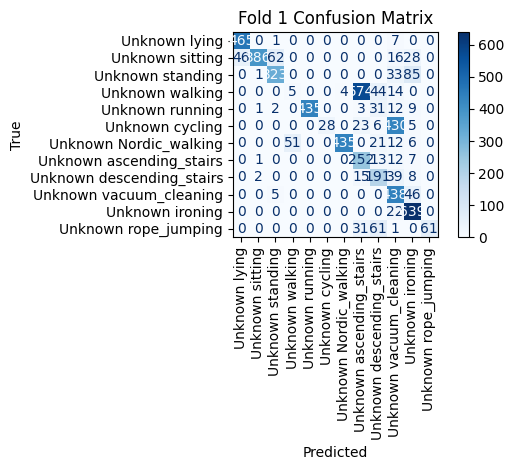


Fold 2 Classification Report:
              precision    recall  f1-score   support

           1       0.98      0.93      0.95       469
           2       0.99      0.78      0.88       447
           3       0.94      0.73      0.82       511
           4       0.93      0.74      0.83       651
           5       0.98      0.94      0.96       185
           6       0.91      0.99      0.95       502
           7       0.98      0.90      0.94       595
          12       0.52      0.86      0.65       347
          13       0.90      0.46      0.61       304
          16       0.53      0.97      0.68       413
          17       0.93      0.93      0.93       578
          24       0.99      0.89      0.94       393

    accuracy                           0.85      5395
   macro avg       0.88      0.84      0.84      5395
weighted avg       0.89      0.85      0.85      5395



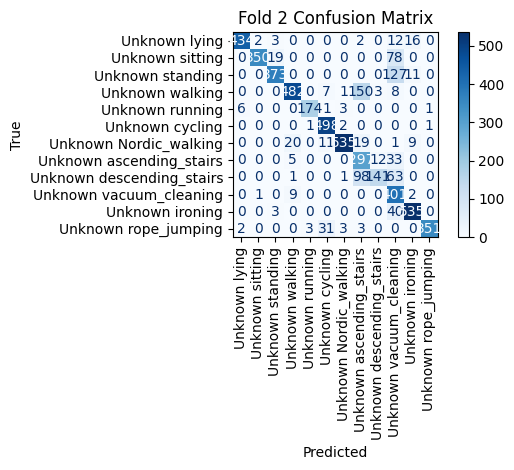


Fold 3 Classification Report:
              precision    recall  f1-score   support

           1       0.72      0.97      0.83       924
           2       0.78      0.86      0.82      1034
           3       0.70      0.52      0.60       914
           4       0.80      0.96      0.87      1210
           5       0.97      0.89      0.93       331
           6       0.95      0.99      0.97       510
           7       0.84      0.80      0.82       577
          12       0.84      0.75      0.79       441
          13       0.81      0.81      0.81       499
          16       0.54      0.71      0.61       893
          17       0.92      0.47      0.62      1219
          24       0.95      0.68      0.79       176

    accuracy                           0.77      8728
   macro avg       0.82      0.78      0.79      8728
weighted avg       0.79      0.77      0.77      8728



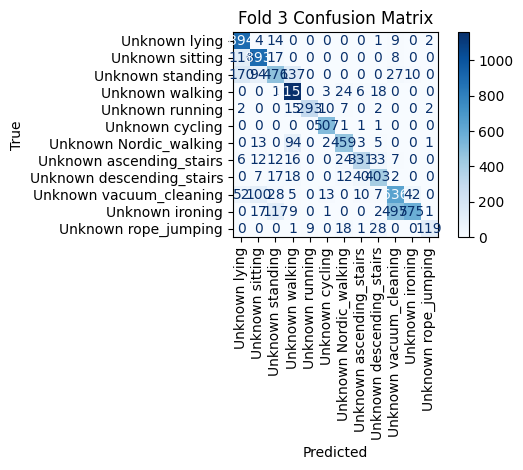


Fold 4 Classification Report:
              precision    recall  f1-score   support

           1       0.99      0.97      0.98       927
           2       0.93      0.93      0.93       971
           3       0.82      0.82      0.82       981
           4       0.57      0.36      0.44      1153
           5       0.98      0.93      0.95       456
           6       0.92      0.94      0.93       864
           7       0.56      0.69      0.62      1085
          12       0.76      0.85      0.80       598
          13       0.85      0.90      0.87       512
          16       0.78      0.88      0.83       823
          17       0.87      0.84      0.85      1255
          24       0.15      1.00      0.27         6

    accuracy                           0.81      9631
   macro avg       0.77      0.84      0.77      9631
weighted avg       0.81      0.81      0.80      9631



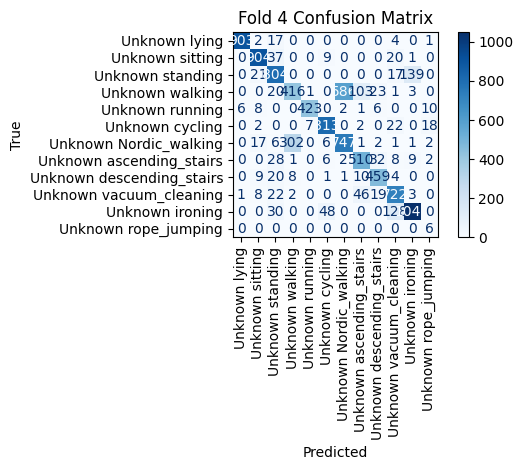


Fold 5 Classification Report:
              precision    recall  f1-score   support

           1       0.69      0.98      0.81      1056
           2       0.86      0.34      0.49       714
           3       0.71      0.56      0.63       950
           4       0.95      0.91      0.93      1119
           5       0.99      0.91      0.95       499
           6       0.94      0.95      0.95       925
           7       0.91      0.77      0.84       980
          12       0.74      0.89      0.81       670
          13       0.82      0.76      0.79       532
          16       0.84      0.77      0.80       890
          17       0.70      0.97      0.81      1061
          24       0.93      0.89      0.91       258

    accuracy                           0.81      9654
   macro avg       0.84      0.81      0.81      9654
weighted avg       0.83      0.81      0.81      9654



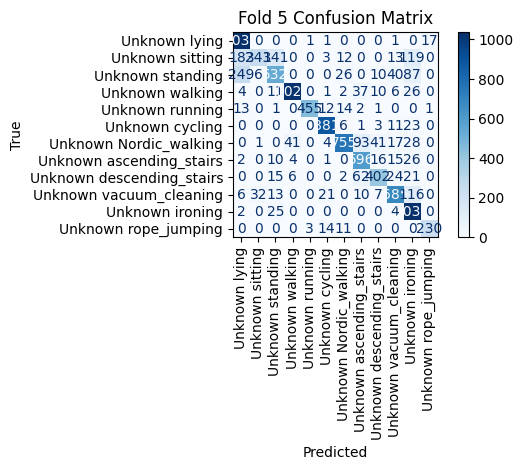

In [ ]:
# GroupKFold Cross-Validation
gkf = GroupKFold(n_splits=5)
fold_metrics = []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    fold_metrics.append(report)

    print(f"\nFold {fold + 1} Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    #plt.figure(figsize=(10, 6))
    #sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    #plt.title(f'Fold {fold + 1} Confusion Matrix')
    #plt.xlabel('Predicted')
    #plt.ylabel('True')
    #plt.show()

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=activity_names)
    disp.plot(cmap='Blues', xticks_rotation=90)
    plt.title(f'Fold {fold + 1} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

In [ ]:
# Average F1-scores across folds
labels = sorted(np.unique(y))

avg_f1_scores = {}
for label in labels:
    f1s = [fold[str(label)]['f1-score'] for fold in fold_metrics if str(label) in fold]
    avg_f1_scores[label] = np.mean(f1s)

print("\nAverage F1-score per class:")
for label, score in avg_f1_scores.items():
    print(f"Activity {label}: {score:.3f}")


Average F1-score per class:
Activity 1: 0.904
Activity 2: 0.789
Activity 3: 0.727
Activity 4: 0.617
Activity 5: 0.945
Activity 6: 0.780
Activity 7: 0.822
Activity 12: 0.696
Activity 13: 0.738
Activity 16: 0.699
Activity 17: 0.815
Activity 24: 0.695


### Feature importance

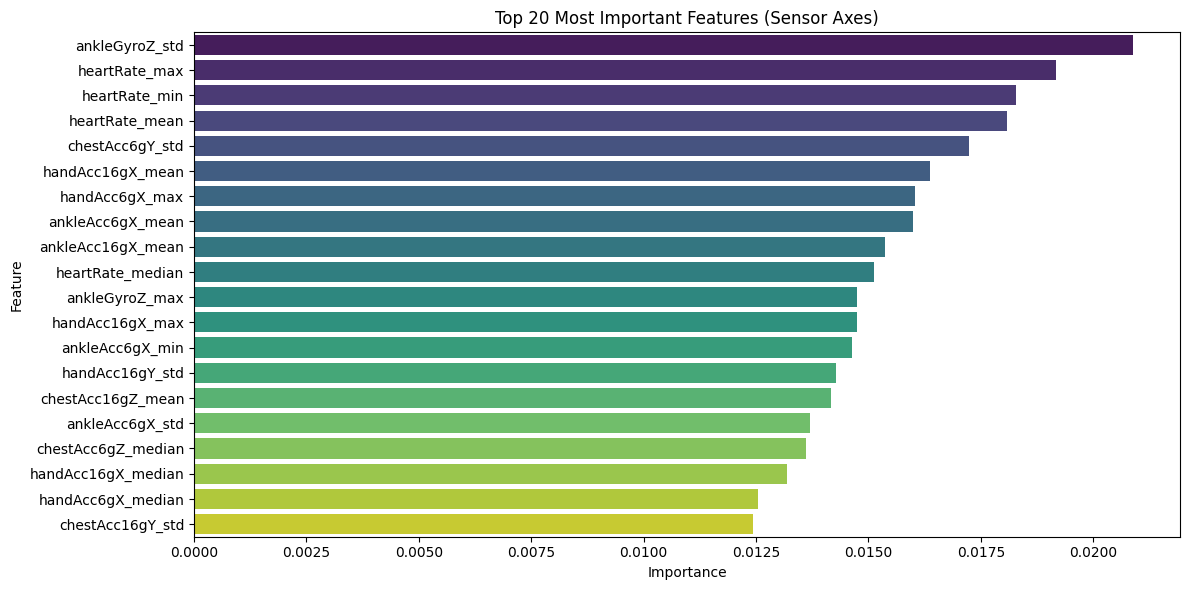

In [ ]:
# Get feature importances
importances = clf.feature_importances_

# Create a DataFrame of feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 20
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', hue='Feature', palette='viridis', legend=False)
plt.title("Top 20 Most Important Features (Sensor Axes)")
plt.tight_layout()
plt.show()

## Alternate model with XGBoost Classifier

### Training XGBoost Classifier

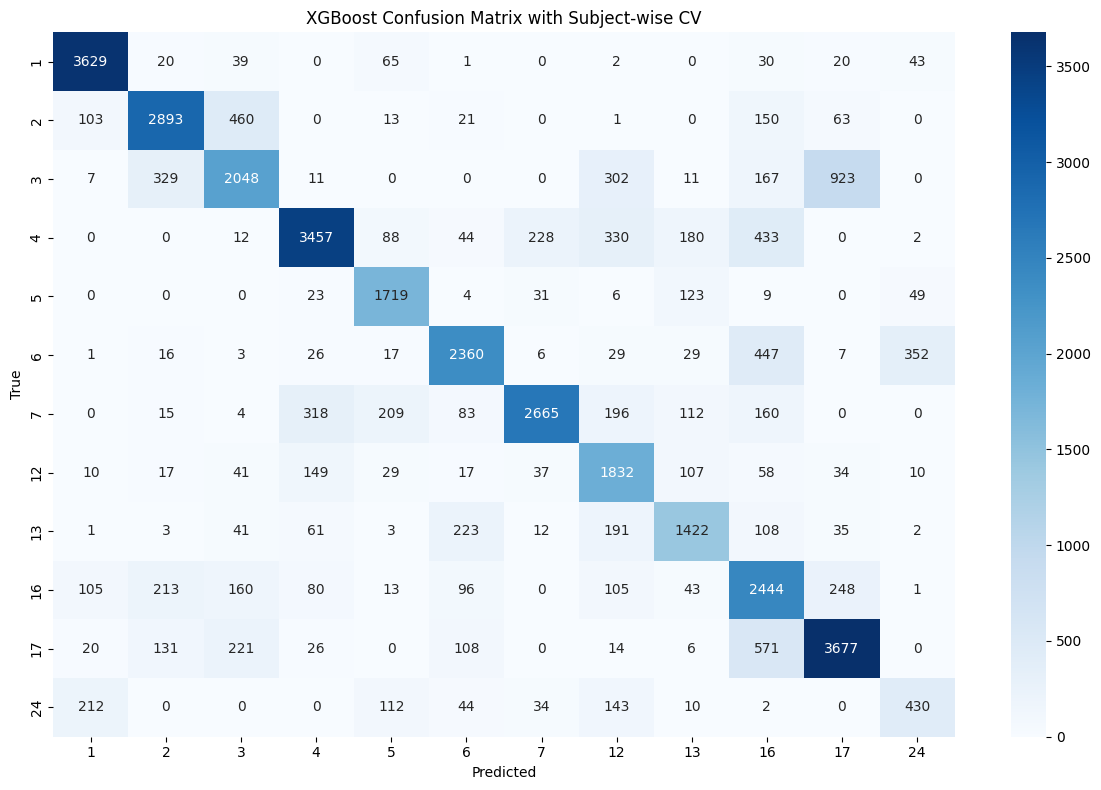

,precision,recall,f1-score,support
1,0.887720,0.942842,0.914451,3849.0
2,0.795436,0.781048,0.788176,3704.0
3,0.676131,0.539231,0.599971,3798.0
4,0.832811,0.724131,0.774678,4774.0
5,0.757937,0.875255,0.812382,1964.0


In [ ]:
# Prepare data
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the target variable y
y_encoded = label_encoder.fit_transform(y)

y_train_encoded = label_encoder.fit_transform(y_train)

# Fit the XGBoost model on the training data
# This is the missing step needed before getting the booster
xgb.fit(X_train, y_train_encoded) # Use the encoded training labels

# Perform subject-wise cross-validation using GroupKFold on the encoded labels
group_kfold = GroupKFold(n_splits=5)
y_pred_encoded = cross_val_predict(xgb, X, y_encoded, cv=group_kfold, groups=groups)

# Inverse transform the encoded labels for display
# Use the label_encoder to transform back to original labels
y_true_labels = label_encoder.inverse_transform(y_encoded)
y_pred_labels = label_encoder.inverse_transform(y_pred_encoded)

# Classification Report
# Use the original activity IDs (now as labels for the report)
report = classification_report(y_true_labels, y_pred_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Confusion Matrix
# Get the sorted unique original labels from the encoder for the confusion matrix
original_labels_for_cm_xgb = sorted(label_encoder.classes_)

cm_xgb = confusion_matrix(y_true_labels, y_pred_labels, labels=original_labels_for_cm_xgb)

plt.figure(figsize=(12, 8))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=original_labels_for_cm_xgb,
            yticklabels=original_labels_for_cm_xgb)
plt.title("XGBoost Confusion Matrix with Subject-wise CV")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

report_df.head()

### Class-wise Feature Importance via SHAP

In [ ]:
# Use raw XGBoost Booster
booster = xgb.get_booster()  # from GridSearchCV or directly if standalone model

# Wrap the explainer around the Booster and training data
explainer = shap.TreeExplainer(booster)

# Use sample
X_sample = pd.DataFrame(X_test, columns=feature_names)

# Get SHAP values
shap_values = explainer.shap_values(X_sample)

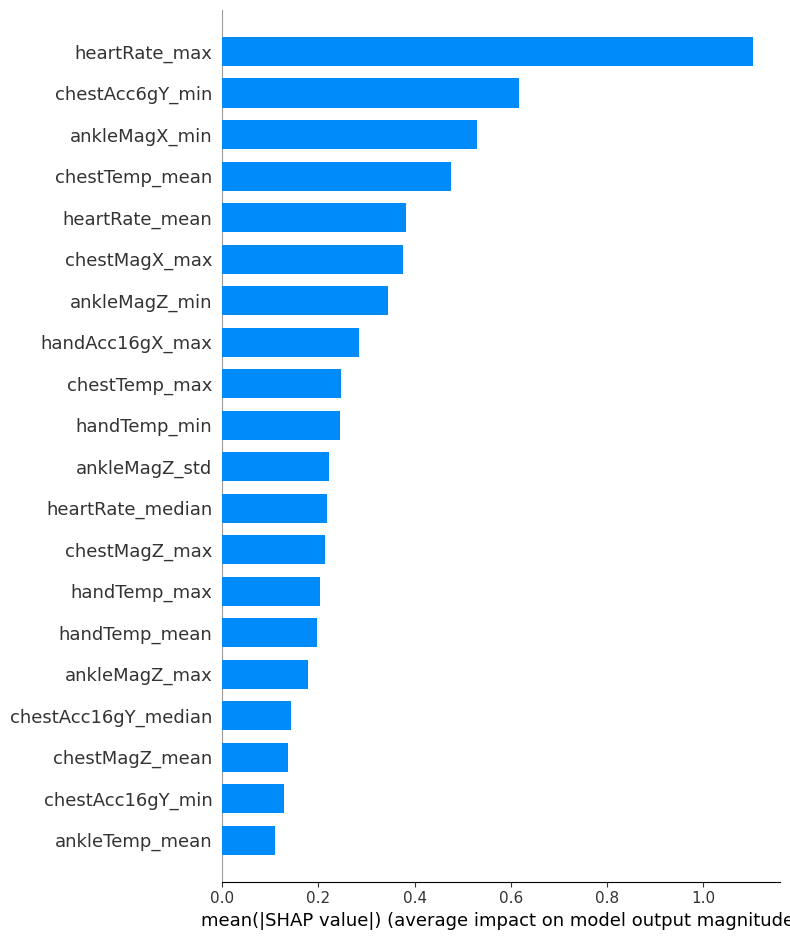

In [ ]:
# Class 3 is at index `label_encoder.transform([3])[0]`
class_index = label_encoder.transform([3])[0]

# Plot summary only for Class 3
# Ensure shap_values for the specific class is a 2D array
# If shap_values is a list of arrays for each class:
if isinstance(shap_values, list):
    shap_values_for_class = shap_values[class_index]
# If shap_values is a 3D numpy array (samples, features, classes):
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    # Select the SHAP values for the target class across all samples and features
    shap_values_for_class = shap_values[:, :, class_index]
else:
    raise TypeError("Unexpected format for shap_values")


shap.summary_plot(shap_values_for_class, X_sample, plot_type='bar')

In [ ]:
# Get indexes for true class 3, predicted as class 16
# Use the xgb model to predict on the X_test data
y_pred_xgb_test = xgb.predict(X_test)

# Now compare y_test and y_pred_xgb_test
misclassified_mask = (y_test == class_index) & (y_pred_xgb_test == label_encoder.transform([16])[0])

# Select the misclassified samples from X_sample
X_misclassified = X_sample[misclassified_mask]

# Check if there are any misclassified samples before proceeding
if X_misclassified.shape[0] > 0:
    # Use a few misclassified examples, convert to numpy array
    # Slicing up to 10 examples ensures we don't try to process too many
    X_sample_misclassified_subset = X_misclassified.iloc[:10].values

    # Get SHAP values for the subset of misclassified samples
    # Pass the numpy array subset to the explainer
    shap_values_mis = explainer.shap_values(X_sample_misclassified_subset)

    # Ensure shap_values_mis for the specific class is a 2D array
    if isinstance(shap_values_mis, list):
        # If shap_values is a list of arrays for each class:
        # Select the SHAP values for the target class across all samples
        shap_values_mis_for_class = shap_values_mis[class_index]
    elif isinstance(shap_values_mis, np.ndarray) and shap_values_mis.ndim == 3:
        # If shap_values is a 3D numpy array (samples, features, classes):
        # Select the SHAP values for the target class across all samples and features
        shap_values_mis_for_class = shap_values_mis[:, :, class_index]
    else:
        raise TypeError("Unexpected format for shap_values_mis")

    # Waterfall plot for the first misclassified example in the subset
    # Ensure we have at least one example to plot
    if shap_values_mis_for_class.shape[0] > 0:
        # Get the features for the first misclassified example in the subset
        features_for_plot = X_misclassified.iloc[0] # Use .iloc[0] on the DataFrame X_misclassified

        shap.plots._waterfall.waterfall_legacy(
            explainer.expected_value[class_index],
            shap_values_mis_for_class[0], # Use the SHAP values for the first sample in the subset
            features=features_for_plot, # Use the corresponding features from the DataFrame
            feature_names=feature_names # Pass feature names for better labeling
        )
    else:
         print("No misclassified samples found for class 3 predicted as class 16 in the test set.")

else:
    print("No misclassified samples found for class 3 predicted as class 16 in the test set.")

No misclassified samples found for class 3 predicted as class 16 in the test set.
